# PBO learnt on several iterations and several weigths

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 2
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Box over states and actions
max_discrete_state = 5
n_discrete_states = 7
max_discrete_action = 5
n_discrete_actions = 7

# Weights collection
n_weights = 500
filtering_weights = True

# Q function
action_range_on_max = max_discrete_action
n_actions_on_max = 50

# PBO training
tolerance = 0.1
max_iterations = 2000
batch_size_samples = 20
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": max_iterations}
max_bellman_iterations = 5

# Optimal linear PBO training
tolerance_linear = 1e-5
max_iterations_linear = 5000
batch_size_weights_linear = n_weights
learning_rate_optimal_linear = {"first": 0.001, "last": 0.00005, "duration": max_iterations_linear}
max_bellman_iterations_linear = 6

# Visualisation
plot_freq = 200
n_iterations = 6
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 0.43056368827819824s + 0.20438933372497559a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.11309254169464111s² + -0.5809967517852783a² + -0.5693705081939697sa


## Collect samples

### Samples on the mesh

In [3]:
import jax.numpy as jnp

from pbo.sample_collection.replay_buffer import ReplayBuffer


n_samples = n_discrete_states * n_discrete_actions
replay_buffer = ReplayBuffer()

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

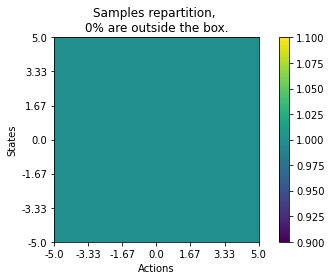

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

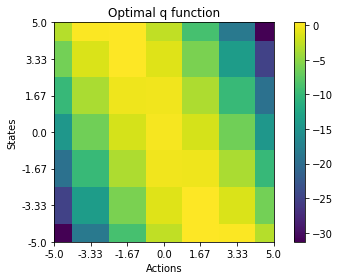

In [5]:
optimal_q = env.optimal_Q_mesh(discrete_states, discrete_actions)

q_visu_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_visu_mesh.set_values(optimal_q)
q_visu_mesh.show("Optimal q function")

## Build q network

In [6]:
from pbo.networks.q import TheoreticalQ


q = TheoreticalQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

## Collect weights

### Random init weights

In [7]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    if not filtering_weights or q.to_params(weights)["TheoreticalQNet"]["m"] < 0 - 0.1:
        weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Build the PBOs network and the dataloaders

In [8]:
from pbo.networks.pbo import LinearPBO, OptimalPBO, OptimalLinearPBO
from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)

data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
data_loader_weights_linear = WeightsDataLoader(weights_buffer, batch_size_weights_linear, shuffle_key)

pbo = LinearPBO(pbo_network_key, q, learning_rate, max_bellman_iterations)
pbo_optimal = OptimalPBO(env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0])
pbo_optimal_linear = OptimalLinearPBO(pbo_network_key, q.weights_dimension, learning_rate_optimal_linear, pbo_optimal, max_bellman_iterations_linear)

## Train the optimal linear PBO

In [9]:
linear_l2_grad_norm = float("inf")
iteration = 0

while linear_l2_grad_norm > tolerance_linear and iteration < max_iterations_linear:
    linear_l2_loss = 0

    data_loader_weights_linear.shuffle()
    for batch_weights in data_loader_weights_linear:
        pbo_optimal_linear.params, pbo_optimal_linear.optimizer_state, l2_loss, l2_grad_loss = pbo_optimal_linear.learn_on_batch(pbo_optimal_linear.params, pbo.optimizer_state, batch_weights)
        linear_l2_loss += l2_loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:
        linear_l2_grad_norm = 0
        for layers in l2_grad_loss.values():
                for grad in layers.values():
                    linear_l2_grad_norm += np.linalg.norm(grad)

        print("linear l2 loss:", linear_l2_loss, "Linear l2 grad loss:", linear_l2_grad_norm)

linear l2 loss: 48.15864 Linear l2 grad loss: 143.92502212524414
linear l2 loss: 47.85002 Linear l2 grad loss: 141.37892150878906
linear l2 loss: 47.956253 Linear l2 grad loss: 142.09853744506836
linear l2 loss: 47.883408 Linear l2 grad loss: 141.33540725708008
linear l2 loss: 48.081383 Linear l2 grad loss: 140.71916580200195
linear l2 loss: 48.242466 Linear l2 grad loss: 141.18737411499023
linear l2 loss: 48.075253 Linear l2 grad loss: 141.70165252685547
linear l2 loss: 47.946735 Linear l2 grad loss: 141.12530517578125
linear l2 loss: 48.149487 Linear l2 grad loss: 140.76851272583008
linear l2 loss: 48.225452 Linear l2 grad loss: 141.38248443603516
linear l2 loss: 47.96394 Linear l2 grad loss: 141.67107391357422
linear l2 loss: 48.019 Linear l2 grad loss: 140.8487663269043
linear l2 loss: 48.194576 Linear l2 grad loss: 140.9160385131836
linear l2 loss: 48.180252 Linear l2 grad loss: 141.56976699829102
linear l2 loss: 47.915398 Linear l2 grad loss: 141.51828002929688
linear l2 loss: 48

## Train PBO on several iteration

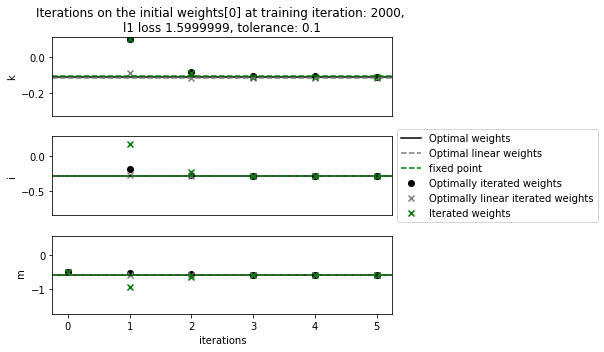

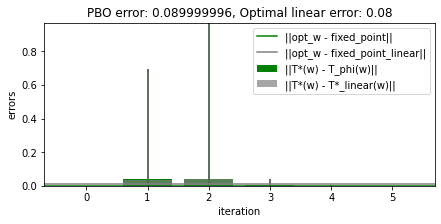

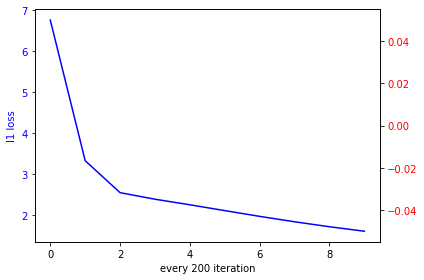

In [10]:
from pbo.utils.weights_iterator import WeightsIterator
from pbo.utils.shared_axis_plot import shared_axis_plot


# For visualization
weights_iterator = WeightsIterator(
    pbo.network.apply, pbo_optimal, pbo_optimal_linear, data_loader_weights.weights, n_iterations,
    env.A[0, 0], env.B[0, 0], env.Q[0, 0], env.R[0, 0], env.S[0, 0], env.P[0, 0], 0
)
full_batch = {
    "state": replay_buffer.states,
    "action": replay_buffer.actions,
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
l1_losses = []

iteration = 0
l1_loss = float("inf")
bellman_iterations = jnp.arange(max_bellman_iterations + 1)

while l1_loss > tolerance and iteration < max_iterations:
    cumulative_l2_loss = 0
    
    data_loader_weights.shuffle()
    for batch_weights in data_loader_weights:
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(pbo.params, pbo.optimizer_state, batch_weights, batch_samples)            
            cumulative_l2_loss += l2_loss

    iteration += 1

    # Visualization
    if iteration % plot_freq == 0:  
        l1_loss = pbo.l1_loss(pbo.params, data_loader_weights.weights, full_batch)

        weights_iterator.iterate_on_params(pbo.params, pbo.fixed_point())
        weights_iterator.show(
            f"Iterations on the initial weights[0] at training iteration: {iteration}, \nl1 loss {str(np.round(l1_loss, 2))}, tolerance: {tolerance}"
        )

        l1_losses.append(l1_loss)


shared_axis_plot(l1_losses, np.array(l1_losses) * np.nan, f"every {plot_freq} iteration", "l1 loss")

## Performances of the operators

In [11]:
l1_loss_optimal_linear = pbo.l1_loss(pbo_optimal_linear.params, data_loader_weights.weights, full_batch)
l1_loss_optimal = pbo_optimal.l1_loss(pbo, q, data_loader_weights.weights, full_batch, max_bellman_iterations)

print("l1 loss", l1_loss)
print("l1 loss optimal linear", l1_loss_optimal_linear)
print("l1 loss optimal", l1_loss_optimal)

l1 loss 1.5996709
l1 loss optimal linear 0.748458
l1 loss optimal 0.5527684


In [12]:
q_thin = TheoreticalQ(
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    action_range_on_max=10 * action_range_on_max,
    n_actions_on_max=10 * n_actions_on_max,
)

pbo_thin = LinearPBO(pbo_network_key, q_thin, learning_rate, max_bellman_iterations)

l1_loss_optimal_thin = pbo_optimal.l1_loss(pbo_thin, q_thin, data_loader_weights.weights, full_batch, max_bellman_iterations)

print("l1 loss optimal thin scale", l1_loss_optimal_thin)

l1 loss optimal thin scale 6.035477


## Visualize iterations on weights

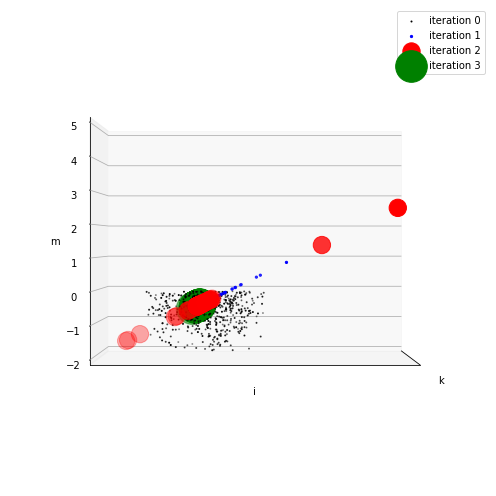

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def add_points(ax, points, size, label, color):
    xdata = points[:, 0]
    ydata = points[:, 1]
    zdata = points[:, 2]
    ax.scatter3D(xdata, ydata, zdata, s=size, label=label, color=color)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
sizes = [1, 5, 300, 1000]
colors = ["black", "b", "red", "g"]
iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal(iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
plt.show()

Contracting facteur 0.13969627


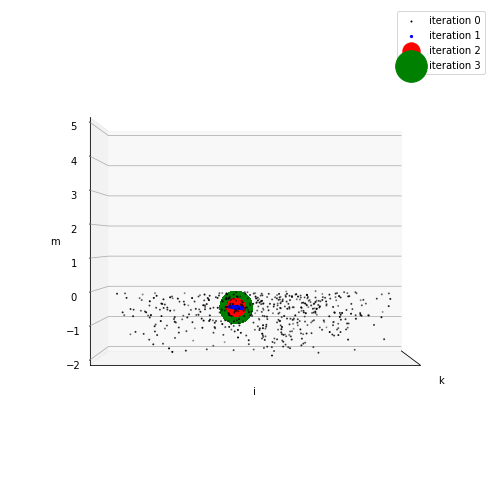

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo_optimal_linear.network.apply(pbo_optimal_linear.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo_optimal_linear.params["LinearPBONet/linear"]["w"], ord=1))

Contracting facteur 0.99002


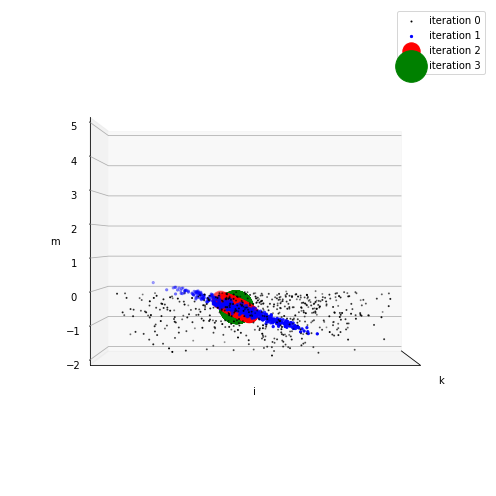

In [15]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

iterated_weights = weights_buffer.weights

for iteration in range(4):
    add_points(ax, iterated_weights, sizes[iteration], f"iteration {iteration}", colors[iteration])
    iterated_weights = pbo.network.apply(pbo.params, iterated_weights)

ax.set_xlabel('k')
ax.set_xticklabels([])
ax.set_xticks([])

ax.set_ylabel('i')
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_zlabel('m')
ax.set_zlim(-2, 5)

ax.legend()
ax.view_init(0, 0)
fig.tight_layout()
print("Contracting facteur", jnp.linalg.norm(pbo.params["LinearPBONet/linear"]["w"], ord=1))